In [149]:
import pandas as pd
import networkx as nx
import glob
import io
import re
import nltk

from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
import operator
from wordcloud import WordCloud

In [5]:
df = pd.read_csv('./tweet_names.csv', encoding ='utf-8')

In [100]:
dem_tweet_doc = []
rep_tweet_doc = []

path = './tweets_2019/*'
for filename in glob.glob(path):
    m = filename[14:]
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()

    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()     
    if party_name == 'Republican':
        rep_tweet_doc += word_tokenize(f)
    else:
        dem_tweet_doc += word_tokenize(f)

In [109]:
for item, handle in df["tw_name"].items():
    rep_tweet_doc = list(filter(lambda a: a != handle, rep_tweet_doc))
    dem_tweet_doc = list(filter(lambda a: a != handle, dem_tweet_doc))

In [110]:
rep_tweet_doc = [item for item in rep_tweet_doc if item.isalpha()]
dem_tweet_doc = [item for item in dem_tweet_doc if item.isalpha()]

In [112]:
stopwords = nltk.corpus.stopwords.words('english')

rep_tweet_doc = [item for item in rep_tweet_doc if item.lower() not in stopwords]
dem_tweet_doc = [item for item in dem_tweet_doc if item.lower() not in stopwords]

In [114]:
rep_tweet_doc = [item.lower() for item in rep_tweet_doc]
dem_tweet_doc = [item.lower() for item in dem_tweet_doc]

In [121]:
def tf_calculator(l):
    tf = {}
    
    for item in l:
        if item in tf:
            tf[item] += 1
        else:
            tf[item] = 1
    
    return tf

In [122]:
rep_tweet_tf = tf_calculator(rep_tweet_doc)
dem_tweet_tf = tf_calculator(dem_tweet_doc)

In [132]:
idf = {}

for word in set(rep_tweet_doc):
    idf[word] = 1

for word in set(dem_tweet_doc):
    if word in idf:
        idf[word] += 1
    else:
        idf[word] = 1

In [133]:
rep_tweet_tfidf = {}
dem_tweet_tfidf = {}

for word in rep_tweet_tf:
    rep_tweet_tfidf[word] = rep_tweet_tf[word] * idf[word]

for word in dem_tweet_tf:
    dem_tweet_tfidf[word] = dem_tweet_tf[word] * idf[word]

In [139]:
sorted_rep_tfidf = sorted(rep_tweet_tfidf.items(), key=operator.itemgetter(1), reverse=True)

In [147]:
rep_cloud_string = ""

for word in sorted_rep_tfidf:
    rep_cloud_string += word[0] + " "

(-0.5, 399.5, 199.5, -0.5)

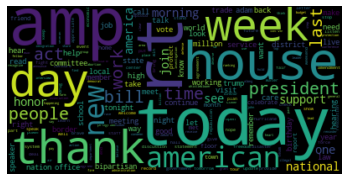

In [150]:
wordcloud = WordCloud().generate(rep_cloud_string)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")